# Recurrent Neural Network for POS TAGGING
> By Juliana Santiago and Luís Eduardo Sales <br>
> Semester: 2025.1 <br>
> Project of NLP Classes from BTI/IMD/UFRN <br>

In [ ]:
# type here the path to Peen Treebank dataset
path = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs0-18 - training"
path_dev = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs19-21 - development" 
path_test = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs22-24 - testing" 

# Preprocessing


### Load Peen Tree Bank Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Tokenization

In this part we are reading database's train data in two ways. First one is saving the tuple (word, POS) in a list with all the words from all the sentences. Second is one that creates a matrix with the words per sentence.

In [ ]:
content = []
content_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)
        content_sentences.extend([pt])

### Building the Vocab

Here we define model's vocabulary. That is, we create the dictionary that will define which Part-Of-Speech we are working with.

In [ ]:
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = {'<PAD>': 0}

In [ ]:
for sent in content:
    word = sent[0]
    tag = sent[1]
    word2idx.setdefault(word.lower(), len(word2idx))
    tag2idx.setdefault(tag, len(tag2idx))

In [ ]:
def index_to_tag(tag2idx):
  return {i: t for t, i in tag2idx.items()}

In [ ]:
idx2tag = index_to_tag(tag2idx)

###  Encoding sentences

In this part we are encoding the sentences with its tuples (words and tags).

In [ ]:
def encode_sentence(sentence, word2idx, tag2idx):
  words_ids = [word2idx.get(word.lower(), word2idx['<UNK>']) for word,_ in sentence]
  tags_ids = [tag2idx[tag] for _,tag in sentence]
  return words_ids, tags_ids

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in content_sentences]

### Padding

The model just accept inputs with the same size, because of the baches, then padding is here to fill the spots in the end that are empty in sentences that are smaller than the longest sentence.

In [ ]:
import tensorflow as tf

In [ ]:
max_len = max(len(x[0]) for x in encoded_sentences)
X = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')

### Convert to Tensor

Neural Network just accept tensors. 

In [ ]:
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [ ]:
X

<tf.Tensor: shape=(38219, 249), dtype=int32, numpy=
array([[   2,    3,    4, ...,    0,    0,    0],
       [  19,    3,   20, ...,    0,    0,    0],
       [  28,   29,    4, ...,    0,    0,    0],
       ...,
       [ 771, 5029, 5030, ...,    0,    0,    0],
       [  10, 5029, 5030, ...,    0,    0,    0],
       [  61,   20, 1023, ...,    0,    0,    0]], dtype=int32)>

# RNN

### Validation Dataset
Read dataset's validation Peen Tree Bank data and add to list.

In [ ]:
#path_dev = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs19-21 - development" 

In [ ]:
dev_sentences = []
with open(path_dev,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        dev_sentences.extend([pt])

In [ ]:
dev_sentences

In [ ]:
import numpy as np

Repeat the process. Codify and proceed with POS PADDING.

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in dev_sentences]
max_len_development = max(len(x[0]) for x in encoded_sentences)
X_development = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = np.expand_dims(y_development, -1)

# Convertendo para tensor
X_development = tf.convert_to_tensor(X_development)
y_development = tf.convert_to_tensor(X_development)

### Model
Model's construction

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
vocab_size = len(word2idx)
num_tags = len(tag2idx)
embedding_dim = 64
rnn_units = 64

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,mask_zero=False),
    layers.SimpleRNN(rnn_units, return_sequences=True),
    layers.TimeDistributed(layers.Dense(num_tags, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ys = tf.expand_dims(y, -1)
history = model.fit(X, ys, epochs=30, batch_size=64, validation_data=(X_development, y_development), validation_freq=5)


Epoch 1/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 101s 83ms/step - accuracy: 0.9046 - loss: 0.4667
Epoch 2/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.9185 - loss: 0.2853
Epoch 3/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9187 - loss: 0.2826
Epoch 4/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9184 - loss: 0.2830
Epoch 5/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.9184 - loss: 0.2828 - val_accuracy: 0.9044 - val_loss: nan
Epoch 6/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9181 - loss: 0.2840
Epoch 7/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9183 - loss: 0.2833
Epoch 8/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9186 - loss: 0.2825
Epoch 9/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9184 - loss: 0.2829
Epoch 10/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9188 - loss: 0.2815 - val_accuracy: 0.9045 - val_loss: nan
Epoch 11/30
598/598 ━━━━━━━━━━━━━━━━━━━━

### Plot Accuracy and Loss

In [ ]:
history.history

{'accuracy': [0.9159533381462097,
  0.9183930158615112,
  0.9183884859085083,
  0.9183791875839233,
  0.9183862805366516,
  0.9183862805366516,
  0.9183772802352905,
  0.9183943271636963,
  0.9183844327926636,
  0.9183721542358398,
  0.9183810353279114,
  0.9183664321899414,
  0.9183891415596008,
  0.9183772802352905,
  0.9183787107467651,
  0.9183906316757202,
  0.9183845520019531,
  0.9183817505836487,
  0.9183791875839233,
  0.9183803200721741,
  0.9183821678161621,
  0.918384313583374,
  0.9183868765830994,
  0.918395459651947,
  0.9183833003044128,
  0.9183863401412964,
  0.9183892011642456,
  0.9183766841888428,
  0.9183844327926636,
  0.9183841943740845],
 'loss': [0.3260229229927063,
  0.28472936153411865,
  0.2834741473197937,
  0.2831892669200897,
  0.2830684781074524,
  0.28304383158683777,
  0.28303301334381104,
  0.28295472264289856,
  0.28297159075737,
  0.2829814553260803,
  0.2829466760158539,
  0.28294768929481506,
  0.28292617201805115,
  0.28292813897132874,
  0.2829

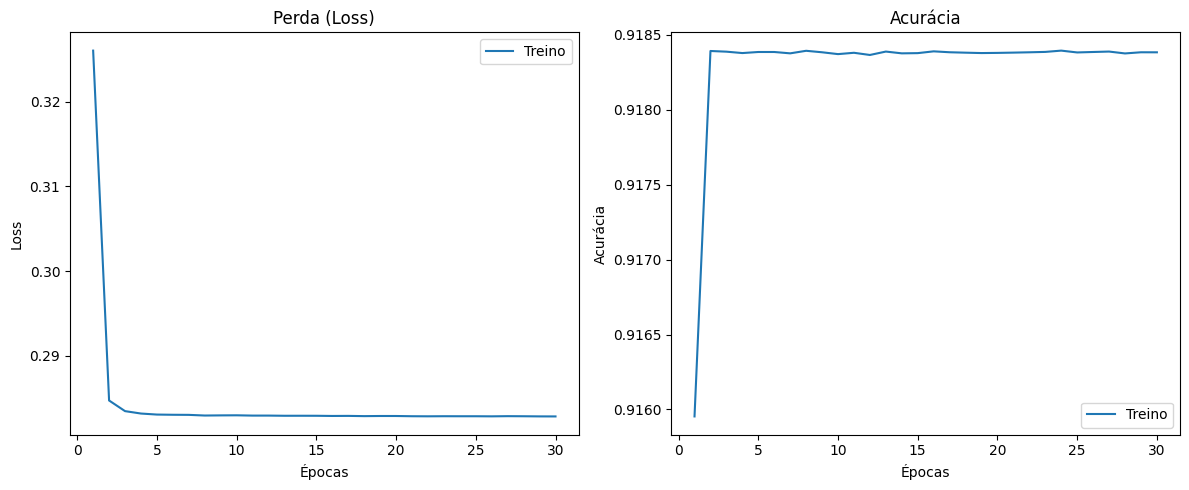

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Treino')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
if 'accuracy' in hist:
    plt.plot(epochs, hist['accuracy'], label='Treino')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


# Save model

In [ ]:
model.save("meu_pos_tagger.h5")

# Load model
> If needed, use the model downloaded in the previous step

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("meu_pos_tagger.h5")

In [ ]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x781ba8f19cd0>

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 249, 64)        │     2,468,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 249, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 249, 46)        │         2,990 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,480,112 (9.46 MB)

 Trainable params: 2,480,110 (9.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Predict

### Colect dataset's test data - repeat the process again

In [ ]:
#path_test = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs22-24 - testing" #Ju

In [ ]:
sentences_test = []
with open(path_test,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_test.extend([pt])

In [ ]:
import numpy as np

### Prediction Function

In [ ]:
def predict_tags(model, sentences, word2idx, idx2tag):
    # Extrair só as palavras da sentença
    words = [w for w, _ in sentences]

    # Converter as palavras para índices
    word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w in words]

    # Fazer padding
    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.int32)

    # Prever
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(words)]]

    return list(zip(words, pred_tags))


Never run the cell bellow with all the sentences_text list. Because dataset's test has about 130k data.

In [ ]:
y_true = []
y_pred = []

for sentence in sentences_test[:1000]:  # Cada item é uma frase: [('The', 'DT'), ('cat', 'NN'), ...]
    true_tags = [tag for _, tag in sentence]
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]

    y_true.extend(true_tags)
    y_pred.extend(predicted_tags)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

# Results (Plots)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average='macro'))


              precision    recall  f1-score   support

           $     0.0000    0.0000    0.0000         2
          ''     0.0000    0.0000    0.0000         3
           ,     0.0000    0.0000    0.0000        12
       -LRB-     0.0000    0.0000    0.0000         2
       -RRB-     0.0000    0.0000    0.0000         2
           .     0.0343    1.0000    0.0664         8
          CC     0.0000    0.0000    0.0000         4
          CD     0.0000    0.0000    0.0000         4
          DT     0.0000    0.0000    0.0000        27
          IN     0.2000    0.0526    0.0833        19
          JJ     0.0000    0.0000    0.0000        19
         JJR     0.0000    0.0000    0.0000         1
          MD     0.0000    0.0000    0.0000         7
          NN     0.0000    0.0000    0.0000        44
         NNP     0.0000    0.0000    0.0000        23
         NNS     0.0000    0.0000    0.0000        10
         POS     0.0000    0.0000    0.0000         2
          RB     0.0000    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-52-106158658.py:16: UserWarnin

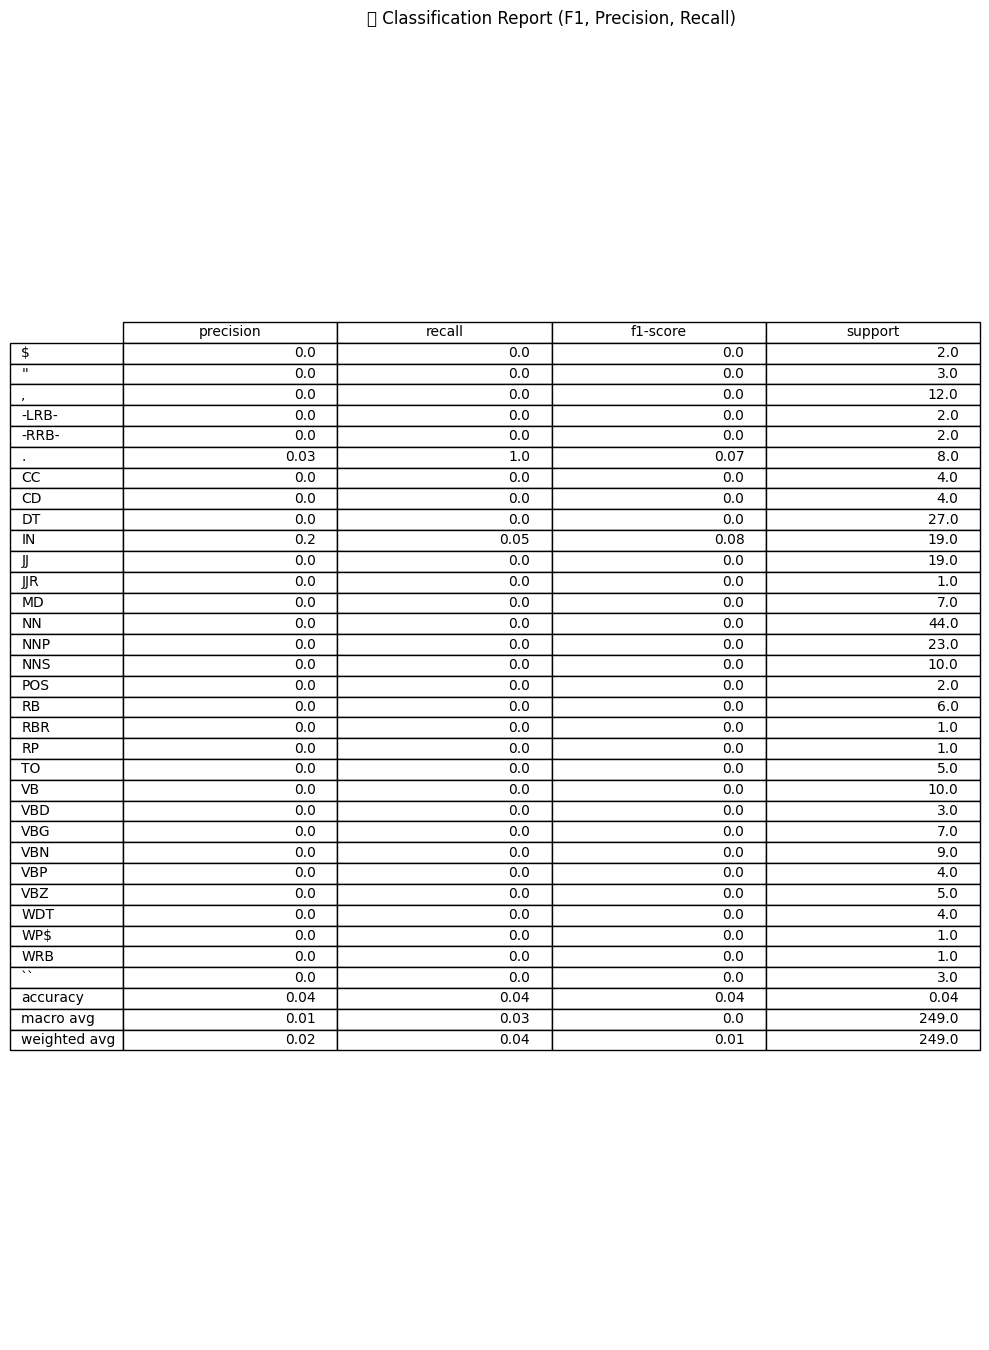

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, digits=4, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(10, len(df_report) * 0.4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.round(2).values,
         colLabels=df_report.columns,
         rowLabels=df_report.index,
         loc='center')
plt.title("📊 Classification Report (F1, Precision, Recall)")
plt.tight_layout()
plt.show()




/tmp/ipython-input-51-1207889945.py:7: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


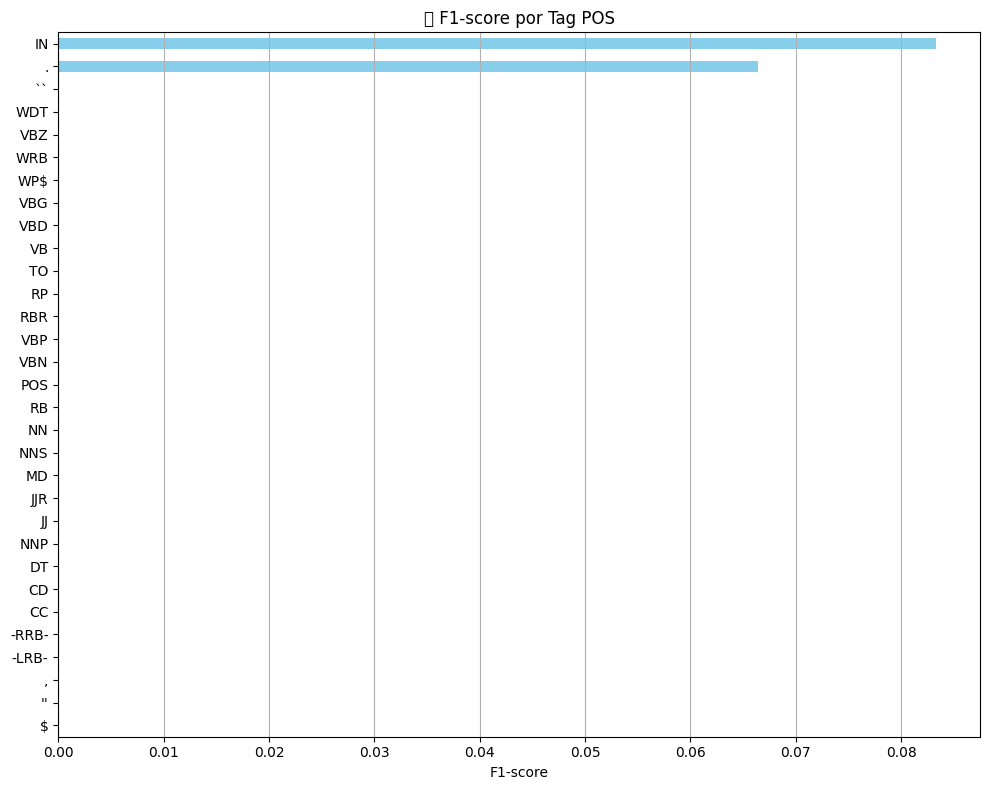

In [ ]:
f1_per_class = df_report.loc[df_report.index.str.len() <= 5].drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')['f1-score']

f1_per_class.sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("F1-score")
plt.title("📌 F1-score por Tag POS")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


/tmp/ipython-input-38-489268921.py:13: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


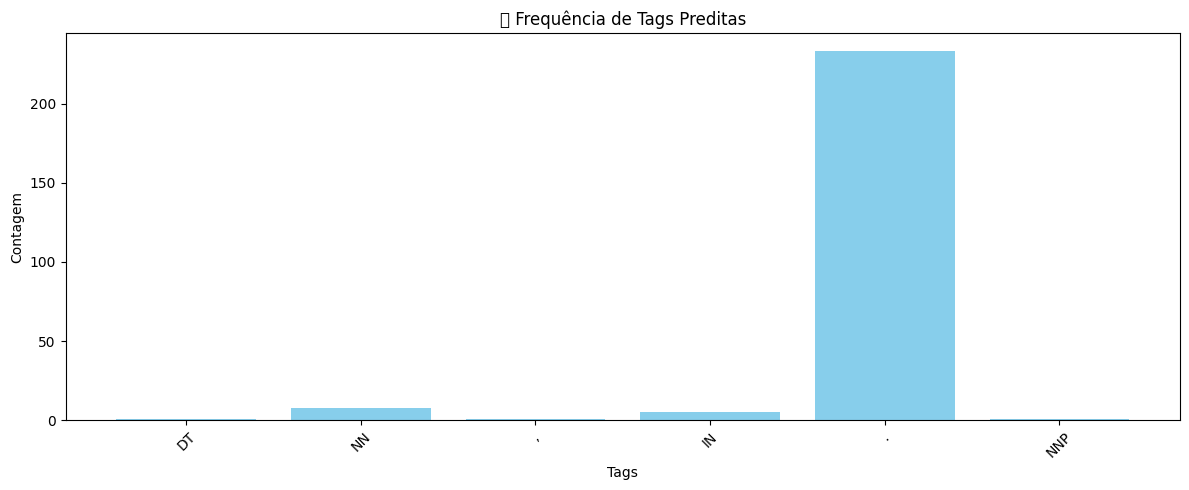

In [ ]:
from collections import Counter

# Conta as tags preditas
tag_counts = Counter(y_pred)

# Plota gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("📌 Frequência de Tags Preditas")
plt.xlabel("Tags")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-42-2512374719.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


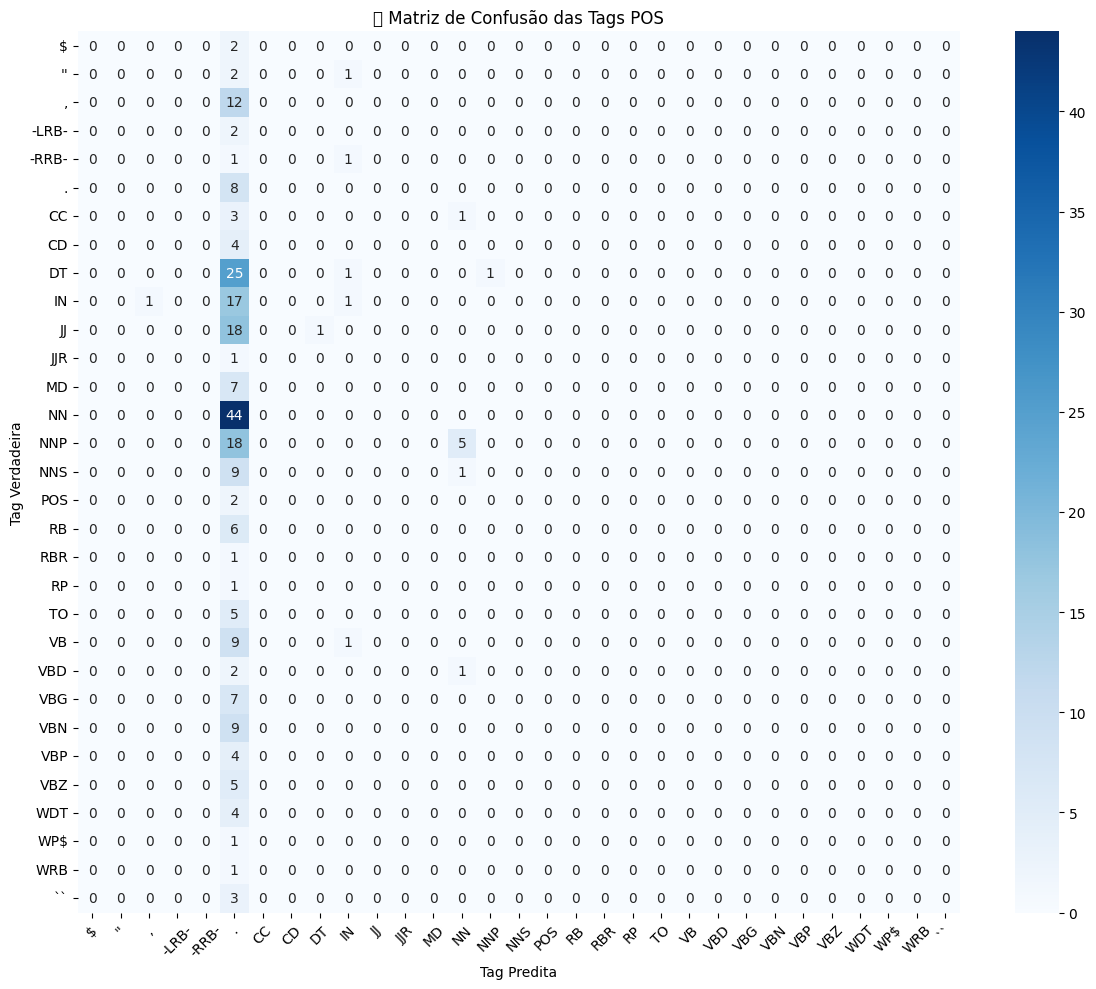

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true + y_pred)))

# Nomes das tags
labels = sorted(set(y_true + y_pred))

# Plot usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Tag Predita")
plt.ylabel("Tag Verdadeira")
plt.title("📊 Matriz de Confusão das Tags POS")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
